# Twitter connection 

In [2]:
# import tweepy
import tweepy as tw
import numpy as np


# your Twitter API key and API secret
my_api_key = "7Itm54s5C6UzzAJiHGdebyAAg"
my_api_secret = "FQikM8b2O7Gsj72jiyYOkbtgIiYhfE13bjWC2EvIzUd3i4cWX5"
access_token = "963549498659262466-dBbkkrXPELf24pJ5MRCUf0GC9YInnXN"
access_token_secret = "KyopfN9fk1220EzPCGcalqwr00lDputoQT1ZrlyoxqmLX"
# authenticate
auth = tw.OAuthHandler(my_api_key, my_api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [3]:
search_query = "#harcelement"

In [4]:
# get tweets from the API
tweets = tw.Cursor(api.search,
              q=search_query,
              lang="fr",
              since="2008-01-01",
              tweet_mode="extended",
              count=1000).items(10000)
# store the API responses in a list
tweets_copy = []
for tweet in tweets:
    tweets_copy.append(tweet)
    



In [5]:
print("Total Tweets fetched:", len(tweets_copy))

Total Tweets fetched: 1235


# Creation du dataset

In [6]:
import pandas as pd
# intialize the dataframe
tweets_df = pd.DataFrame()
# populate the dataframe
tmp = []
for tweet in tweets_copy:
    hashtags = []
    try:
        for hashtag in tweet.entities["hashtags"]:
            hashtags.append(hashtag["text"])
        text = api.get_status(id=tweet.id, tweet_mode='extended').full_text
    except:
        pass
    tmp.append(text) 

In [7]:
print(len(tmp))

1235


# Detoxify annotation

In [8]:
pip install detoxify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 35.8 MB/s 
     |████████████████████████████████| 1.2 MB 38.9 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 54.4 MB/s 
     |████████████████████████████████| 6.6 MB 55.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [9]:
from detoxify import Detoxify

toxicity = []

for t in tmp:
  toxicity.append(Detoxify('multilingual').predict(t)["toxicity"])

print(toxicity[0:5])

Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.4-alpha/multilingual_debiased-0b549669.ckpt" to /root/.cache/torch/hub/checkpoints/multilingual_debiased-0b549669.ckpt


  0%|          | 0.00/1.04G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

[0.0027777161, 0.008552195, 0.0018289117, 0.0019083514, 0.00074923044]


In [10]:
annotated = []
for e in toxicity:
  if e < 0.5:
    annotated.append(1)
  else:
    annotated.append(0) 

# Exportation vers csv

In [11]:
dataset = pd.DataFrame(list(zip(tmp, annotated))  ,columns = ["tweet","toxicity"])
dataset.to_csv("dataset.csv", index = False)

# Performing EDA

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.model_selection import train_test_split
import os

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
df = pd.read_csv('./dataset.csv')
df.shape

(1235, 2)

In [15]:
df.isnull().sum()

tweet       0
toxicity    0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


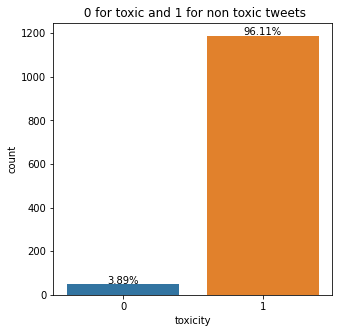

In [16]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
total = float(len(df["toxicity"]))

cntplot = sns.countplot(df["toxicity"])
cntplot.set_title(' 0 for toxic and 1 for non toxic tweets')

for p in ax.patches:
    # Get height.
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

# On a des classe qui ne sont pas equilibré, donc on peut faire soit un under-sampling pour classe 1 ou over-sampling pour classe 0.

# preprocessing text

In [17]:
stemmer = SnowballStemmer("french")
stop_words = set(stopwords.words('french'))

def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

In [18]:
df["tweet"] = df["tweet"].apply(preprocess)

In [19]:
# Break off validation set from training data

y = df.toxicity
X = df.tweet



In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
import pickle
from sklearn.pipeline import Pipeline


x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)


tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, 
                        max_features=700, 
                        ngram_range=(1,1))
prediction_pipeline_svm = Pipeline([('vectorizer', tfidf), 
                                ('svc_model', SVC(kernel='linear'))])
prediction_pipeline_xgb = Pipeline([('vectorizer', tfidf), 
                                ('xgb_model', XGBRegressor(n_estimators=100, learning_rate=0.05))])
prediction_pipeline_rfr = Pipeline([('vectorizer', tfidf), 
                                ('rfr_model', RandomForestRegressor(n_estimators=100, random_state=0))])


prediction_pipeline_svm.fit(x_train,y_train)
prediction_pipeline_xgb.fit(x_train,y_train)
prediction_pipeline_rfr.fit(x_train,y_train)



#testing and evaluation 

#Make prediction on the test set

pred_svm = np.round(prediction_pipeline_svm.predict(x_test))
pred_xgb = np.round(prediction_pipeline_xgb.predict(x_test))
pred_rfr = np.round(prediction_pipeline_rfr.predict(x_test))


#calculating precision and recall

print("RandomForest precision  {}, Recall  {}".format(precision_score(list(y_test), pred_rfr) , recall_score(list(y_test), pred_rfr)))
print("SVM precision  {}, Recall  {}".format(precision_score(y_test, pred_svm) , recall_score(list(y_test), pred_svm)))
print("XGBoost precision  {}, Recall  {}".format(precision_score(y_test, pred_xgb) , recall_score(list(y_test), pred_xgb)))

#F1 score
print("F1 score of RandomForest model : {}".format(f1_score(y_test, pred_rfr)))
print("F1 score of SVM model : {}".format(f1_score(y_test, pred_svm)))
print("F1 score of XGBoost model : {}".format(f1_score(y_test, pred_xgb)))

#Mean absolute error
print("Mean squared error of RandomForest model : {}".format(mean_absolute_error(pred_rfr, y_test)))
print("Mean squared error of SVM model : {}".format(mean_absolute_error(pred_svm, y_test)))
print("Mean squared error of XGBoost model : {}".format(mean_absolute_error(pred_xgb, y_test)))


#saving the model
#xgbr.save_model("xgboost_model.json")
from joblib import dump
dump(prediction_pipeline_svm, 'prediction_pipline_svm.json')


[14:18:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RandomForest precision  0.995850622406639, Recall  0.995850622406639
SVM precision  0.9958677685950413, Recall  1.0
XGBoost precision  0.995850622406639, Recall  0.995850622406639
F1 score of RandomForest model : 0.995850622406639
F1 score of SVM model : 0.9979296066252588
F1 score of XGBoost model : 0.995850622406639
Mean squared error of RandomForest model : 0.008097165991902834
Mean squared error of SVM model : 0.004048582995951417
Mean squared error of XGBoost model : 0.008097165991902834


['prediction_pipline_svm.json']